In [157]:
import pygame, sys, random
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import pylab

num_episodes = 10

agentRadius = 10

# get size of state and action from environment

boundaryPos = [400, 590]
boundaryLength = [70, 70]
initPosAgent = [boundaryPos[0] + boundaryLength[0] / 2, boundaryPos[1] + boundaryLength[1] / 2]#[boundaryPos[0], boundaryPos[1] + boundaryLength[1]]
goalPos = [boundaryPos[0] + boundaryLength[0], boundaryPos[1]]

moveObstacles = True
action_size = 9
obsNumber = 1
# state_size = obsNumber * 2 + 1
state_size = 3
# state_size = obsNumber + 1

In [2]:
# A2C(Advantage Actor-Critic) agent
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.load_model = True
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.00002
        self.critic_lr = 0.00005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./Practice004_DataSave/Actor.h5")
            self.critic.load_weights("./Practice004_DataSave/Critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_normal'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='glorot_normal'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        # Policy = 확률. 이 확률에 맞게 Action을 선택
        print policy
        return np.random.choice(self.action_size, 1, p=policy)[0]
#         return policy

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [3]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < boundaryPos[0]):
        xPos = boundaryPos[0]
        flagWall = -1
    elif(xPos > boundaryPos[0] + boundaryLength[0]):
        xPos = boundaryPos[0] + boundaryLength[0]
        flagWall = -1
    if(yPos < boundaryPos[1]):
        yPos = boundaryPos[1]
        flagWall = -1
    elif(yPos > boundaryPos[1] + boundaryLength[1]):
        yPos = boundaryPos[1] + boundaryLength[1]
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [4]:
def ckInit(initLoc, obsLoc):
    if math.sqrt((initLoc[0] - obsLoc[0])**2 + (initLoc[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        if initLoc[0] - obsLoc[0] < 0:
            obsLoc[0] += 1
        else:
            obsLoc[0] -= 1
        if initLoc[1] - obsLoc[1] < 0:
            obsLoc[1] += 1
        else:
            obsLoc[1] -= 1
    if math.sqrt((goalPos[0] - obsLoc[0])**2 + (goalPos[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        obsLoc[0] -= 1
        obsLoc[1] += 1
    return obsLoc

In [5]:
def stateGenerator(obsPosition, agtPosition, idx):
    returnSum = []
    returnSum = returnSum + [agtPosition[0] - obsPosition[idx][0], agtPosition[1] - obsPosition[idx][1]]
    returnSum = returnSum + [math.sqrt((agtPosition[0] - goalPos[0])**2 + (agtPosition[1] - goalPos[1])**2)]
    returnSum = np.reshape(returnSum, [1, 3])
    return returnSum

In [158]:
def ckCollision(obsPosition, agtPosition):
    for i in range(0,obsNumber):
        if math.sqrt((agtPosition[0] - obsPosition[i][0])**2 + (agtPosition[1] - obsPosition[i][1])**2) <= 20:
            return True
        else:
            return False

In [6]:
def takeAction(action):
    xAction = 0
    yAction = 0
    if action == 0:
        xAction = 1
    elif action == 1:
        xAction = 1
        yAction = 1
    elif action == 2:
        xAction = 1
        yAction = -1            
    elif action == 3:
        xAction = -1
        yAction = 1
    elif action == 4:
        xAction = -1
    elif action == 5:
        xAction = -1
        yAction = -1
    elif action == 6:
        yAction = -1
    elif action == 7:
        yAction = 1
    elif action  == 8:
        xAction = 0
        yAction = 0
        
    return [xAction, yAction]

In [175]:
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

# make A2C agent
agent = A2CAgent(state_size, action_size)

rList, episodes = [], []

# Make Obstacles (obsNumber)
obstaclePos = [[0, 0] for _ in range(obsNumber)]
for i in range(0,obsNumber):
    while True:
        obstaclePos[i][0] = boundaryPos[0] + random.randrange(1, boundaryLength[0])
        obstaclePos[i][1] = boundaryPos[1] + random.randrange(1, boundaryLength[1])
        if obstaclePos[i][0] <= goalPos[0] - agentRadius or obstaclePos[i][0] >= goalPos[0] + agentRadius:
            if obstaclePos[i][1] >= goalPos[1] + agentRadius or obstaclePos[i][1] <= goalPos[1] - agentRadius:
                if obstaclePos[i][0] <= initPosAgent[0] - agentRadius or obstaclePos[i][0] >= initPosAgent[0] + agentRadius:
                    if obstaclePos[i][1] >= initPosAgent[1] + agentRadius or obstaclePos[i][1] <= initPosAgent[1] - agentRadius:
                        break

for e in range(num_episodes):
    # Initialize
    done = False
    score = 0
    x = initPosAgent[0]#boundaryPos[0]
    y = initPosAgent[1]#boundaryPos[1]
    print("Episode ", e, "Starts!")
    #state = np.reshape(state, [1, state_size])
    tmpX = 0
    tmpY = 0
    while not done:
        getPolicy = []
#         tmpPolicyA = []
#         tmpPolicyB = []
        
        for i in range(0, obsNumber):
            state = stateGenerator(obstaclePos, [x,y], i)
#             [action, badAction] = agent.get_action(state)
#             tmpPolicyA = np.log(agent.get_action(state))
            action = agent.get_action(state)
#             if(i > 0):
#                 getPolicy = np.add(tmpPolicyA, getPolicy)
#                 getPolicy = np.multiply(tmpPolicyA, getPolicy)
#             else:
#                 getPolicy = tmpPolicyA
#             print("Local",i,":", tmpPolicyA)
#         getPolicy = np.exp(getPolicy)
#         getPolicy = getPolicy / sum(getPolicy)
#             action = np.random.choice(action_size, 1, p = getPolicy)[0]
#         print("Total:", getPolicy)
            
            xMove = 0
            yMove = 0

            [xMove, yMove] = takeAction(action)
            
#             tmpX = tmpX + xMove
#             tmpY = tmpY + yMove
            x = x + xMove
            y = y + yMove
            
            if ckCollision(obstaclePos, [x,y]) == True:
                print("Collision Predicted!")
                x = x - xMove
                y = y - yMove
            
            wallFlag = 0
            collisionFlag = 0
#         if tmpX != 0 or tmpY != 0:
#             x = int(round(x + tmpX / math.sqrt(tmpX**2 + tmpY**2)))
#             y = int(round(y + tmpY / math.sqrt(tmpX**2 + tmpY**2)))
        print "====================================================="
        [x, y, wallFlag] = ckWall(x,y)
        pygame.draw.circle(screen, [100, 100, 255], [x,y], 10, 0)
#         next_state = stateGenerator(obstaclePos, [x,y])

        if(math.sqrt((x - goalPos[0])**2 + (y - goalPos[1])**2) <= 20):
            print("Goal Reached!")           
            collisionFlag = 1
            done = 1
                
        for i in range(0,obsNumber):
            if moveObstacles:
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                obstaclePos[i] = ckInit(initPosAgent ,obstaclePos[i])

            pygame.draw.circle(screen, [255, 50 + 20*i, 50 + 20 * i], obstaclePos[i], 10, 0)
            if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                print("Collision!")
                collisionFlag = -1
                ObjectIndex = i
                done = True 
#         if wallFlag == -1:
#             done = True
            
        if not done:
            reward = -0.1
            if wallFlag == -1:
                reward = -1
        else:
            if collisionFlag == 1:
                reward = 10000
                rList.append(1)
            elif collisionFlag == -1:
                reward = -10000
                rList.append(0)
#             next_state, reward, done, ininitPosAgentfo = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else -100
        
#         agent.train_model(state, action, reward, next_state, done)

        score += reward
#         state = next_state

        if done:
            # every episode, plot the play time

            episodes.append(e)
            pylab.plot(episodes, rList, 'b')
#             pylab.savefig("./Practice004_DataSave/ActorCriticGraph_Test.png")
        #circle(Surface, color, pos, radius, width=0)
        pygame.draw.circle(screen, [100,255,100], [goalPos[0],goalPos[1]], 10, 2)
        #rect(Surface, color, Rect, width=0)
        pygame.draw.rect(screen, [255,100,100],[boundaryPos[0] - agentRadius, boundaryPos[1] - agentRadius, boundaryLength[0] + agentRadius * 2, boundaryLength[1] + agentRadius * 2],2)
        pygame.display.flip()
        screen.fill([200,200,200])
    print score
    # save the model
#     if e % 50 == 0:
#         agent.actor.save_weights("./Practice004_DataSave/Actor.h5")
#         agent.critic.save_weights("./Practice004_DataSave/Critic.h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_593 (Dense)            (None, 128)               512       
_________________________________________________________________
dense_594 (Dense)            (None, 9)                 1161      
Total params: 1,673
Trainable params: 1,673
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_595 (Dense)            (None, 128)               512       
_________________________________________________________________
dense_596 (Dense)            (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
('Episode ', 0, 'Starts!')
[  2.13857751e-11   1.47365392e-06   9.99415874e-

('Episode ', 2, 'Starts!')
[  1.63611637e-12   1.17286532e-07   9.99922752e-01   0.00000000e+00
   8.06052503e-06   3.83506049e-05   2.53214312e-05   3.03971035e-07
   5.17044828e-06]
[  1.60613460e-12   8.26469773e-08   9.99948144e-01   0.00000000e+00
   4.75183651e-06   2.46624695e-05   1.91157087e-05   2.22168353e-07
   3.07040477e-06]
[  6.92258262e-13   2.62328630e-08   9.99981165e-01   0.00000000e+00
   1.22336337e-06   7.96917993e-06   8.71614702e-06   7.47763949e-08
   8.75897342e-07]
[  5.97789125e-13   1.68209855e-08   9.99988556e-01   0.00000000e+00
   6.44256488e-07   4.67223799e-06   5.62451896e-06   5.05528135e-08
   4.53259901e-07]
[  6.90564576e-13   1.42455336e-08   9.99992013e-01   0.00000000e+00
   4.44791453e-07   3.39833673e-06   3.96681844e-06   4.60877025e-08
   2.77597934e-07]
[  7.49093008e-13   1.15471446e-08   9.99993443e-01   0.00000000e+00
   3.09432977e-07   2.55929899e-06   3.49522566e-06   3.70749689e-08
   2.11093862e-07]
[  1.06104340e-12   1.22133992e

Goal Reached!
9998.0
('Episode ', 4, 'Starts!')
[  1.62392533e-13   1.30341631e-08   9.99981999e-01   0.00000000e+00
   8.77543528e-07   6.74380635e-06   9.27369820e-06   3.09670156e-08
   1.05771232e-06]
[  2.26359187e-13   1.24853798e-08   9.99984860e-01   0.00000000e+00
   7.19814921e-07   5.33694265e-06   8.36942399e-06   3.14613651e-08
   7.74434682e-07]
[  2.15891500e-13   8.63196448e-09   9.99989629e-01   0.00000000e+00
   4.14825962e-07   3.36923358e-06   6.10382767e-06   2.26216681e-08
   4.46553372e-07]
[  2.29393571e-13   7.11774817e-09   9.99991536e-01   0.00000000e+00
   2.95068787e-07   2.58842533e-06   5.30339003e-06   1.82354629e-08
   3.39546972e-07]
[  2.68800363e-13   5.94638960e-09   9.99993920e-01   0.00000000e+00
   2.00245125e-07   1.85375382e-06   3.77401261e-06   1.65540346e-08
   2.07600181e-07]
[  1.00389755e-13   1.82818205e-09   9.99997973e-01   0.00000000e+00
   4.94972703e-08   5.82751454e-07   1.48305298e-06   5.45792300e-09
   5.38483995e-08]
[  1.98300

9998.0
('Episode ', 6, 'Starts!')
[  6.59594178e-13   3.57337875e-08   9.99944687e-01   0.00000000e+00
   2.43385307e-06   2.70103883e-05   2.17489578e-05   9.17352594e-08
   4.00784938e-06]
[  8.25291170e-13   4.01731270e-08   9.99950290e-01   0.00000000e+00
   2.28203203e-06   2.19258491e-05   2.18160530e-05   9.96321887e-08
   3.56743681e-06]
[  6.58345503e-13   2.91098541e-08   9.99968529e-01   0.00000000e+00
   1.45524643e-06   1.19095939e-05   1.59158990e-05   6.44380904e-08
   1.98000907e-06]
[  1.05966440e-12   3.48940219e-08   9.99967217e-01   0.00000000e+00
   1.55267298e-06   1.17607733e-05   1.72721084e-05   7.55587095e-08
   2.00919317e-06]
[  6.92835709e-13   1.61666893e-08   9.99983311e-01   0.00000000e+00
   6.20904245e-07   4.98690088e-06   1.02835229e-05   3.74455631e-08
   7.76071829e-07]
[  5.95388810e-13   1.04151168e-08   9.99989748e-01   0.00000000e+00
   3.28918873e-07   2.93931498e-06   6.61564172e-06   2.53532466e-08
   4.01851537e-07]
[  8.62418427e-13   1.12

9998.0
('Episode ', 8, 'Starts!')
[  2.30044228e-13   1.76306809e-08   9.99978185e-01   0.00000000e+00
   1.21305254e-06   8.31679063e-06   1.09768043e-05   4.29421405e-08
   1.30440253e-06]
[  1.64990322e-13   9.52746415e-09   9.99987006e-01   0.00000000e+00
   5.54760391e-07   4.34505819e-06   7.49393848e-06   2.33047306e-08
   6.48852847e-07]
[  1.28053045e-13   5.20115195e-09   9.99993324e-01   0.00000000e+00
   2.41187081e-07   2.12762552e-06   4.08595815e-06   1.41738372e-08
   2.57572253e-07]
[  4.78488573e-14   1.57347990e-09   9.99997616e-01   0.00000000e+00
   5.86294000e-08   6.58474619e-07   1.59659146e-06   4.55864591e-09
   6.58037393e-08]
[  3.01365141e-14   7.96753996e-10   9.99998689e-01   0.00000000e+00
   2.47292480e-08   3.25377584e-07   9.34772515e-07   2.37077780e-09
   2.93800397e-08]
[  2.09124286e-14   4.09668161e-10   9.99999404e-01   0.00000000e+00
   9.96579352e-09   1.50154378e-07   4.48962737e-07   1.39333201e-09
   1.05749169e-08]
[  1.74887265e-14   2.84

Percent of successful episodes: 20.0%


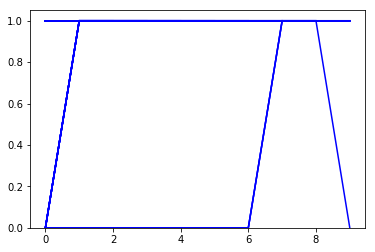

In [171]:
print("Percent of successful episodes: " + str(100.0 * sum(rList)/num_episodes) + "%")

plt.bar(range(len(rList)), rList, color = "Blue", width = 0.00001)
plt.show()